#Directional test

Confronto di due modelli, uno bidirezionale, l'altro unidirezionale, con gli stessi parametri e con molte epoche (1000).

Testato il modello CuDNN LSTM. 

Il database è identico, nello stesso ordine per entrambi i modelli.

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
from tensorflow import keras as ks


import numpy as np
import pandas as pd

import time
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage.transform import resize

import cv2

#Data visualization
import seaborn as sns

from matplotlib import pyplot as plt

import glob
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os, os.path

#Per modello NN
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import CuDNNLSTM
'''
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax
#from tensorflow.keras.layers import Dropout
#from tensorflow.keras.layers import Conv2D
'''
print(tf.__version__)

1.15.2


In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

!git clone https://github.com/PaoloDarienzo/NN_modules.git
!mv NN_modules/Defining_Methods.py /content
!rm -rf NN_modules

import Defining_Methods as my_lib

Cloning into 'NN_modules'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 163 (delta 4), reused 0 (delta 0), pack-reused 155
Receiving objects: 100% (163/163), 2.83 MiB | 2.63 MiB/s, done.
Resolving deltas: 100% (83/83), done.


#Modello bi-direzionale

In [4]:
database_scelto = '18k' #or '14k' or '9k'

dim1 = 128
dim2 = 64
batch_size = 4096

#Unit in first layer
num_units1 = 141
num_units2 = 94
channels = 1

time_steps = dim1
n_features = dim2

n_epochs = 2000
patience = 2000

In [5]:
sets_and_labels, numpy_arrays, label_encoder, n_classes = my_lib.get_dataset_crop(database_scelto, batch_size, dim1, dim2, drive)

train_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded = sets_and_labels
_, _, validation_obf = numpy_arrays

sub_db = (train_images, train_labels_encoded, test_images, test_labels_encoded)

18800
START IMAGE INPUT
END IMAGE INPUT


In [ ]:
modelBi, histB, time_callbackB = my_lib.modelLSTM(num_units1, num_units2, time_steps, n_features, batch_size, n_classes, patience, sub_db, n_epochs)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
number_of_epochs_it_ran = len(histB.history['loss'])

time_per_epoch = time_callbackB.times
total_time = sum(time_per_epoch)

test_accuracy = modelBi.evaluate(validation_images, validation_labels_encoded)
print("Total epochs", number_of_epochs_it_ran)
print(str(total_time), "s")

#Modello uni-direzionale

In [ ]:
database_scelto = '18k' #or '14k' or '9k'

dim1 = 128
dim2 = 64
batch_size = 4096

#Unit in first layer
num_units1 = 141
num_units2 = 94
channels = 1

time_steps = dim1
n_features = dim2

n_epochs = 2000
patience = 2000

In [ ]:
'''

sets_and_labels, numpy_arrays, label_encoder, n_classes = my_lib.get_dataset_crop(database_scelto, batch_size, dim1, dim2, drive)

train_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded = sets_and_labels
_, _, validation_obf = numpy_arrays

sub_db = (train_images, train_labels_encoded, test_images, test_labels_encoded)

'''

'\n\nsets_and_labels, numpy_arrays, label_encoder, n_classes = my_lib.get_dataset_crop(database_scelto, batch_size, dim1, dim2, drive)\n\ntrain_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded = sets_and_labels\n_, _, validation_obf = numpy_arrays\n\nsub_db = (train_images, train_labels_encoded, test_images, test_labels_encoded)\n\n'

In [ ]:
modelU = ks.Sequential()

modelU.add(CuDNNLSTM(num_units1, input_shape=(time_steps, n_features), unit_forget_bias='true', return_sequences='true'))
modelU.add(CuDNNLSTM(num_units2, unit_forget_bias='true'))
modelU.add(Dense(n_classes, activation='softmax'))

modelU.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Definizione callback
es = ks.callbacks.EarlyStopping(monitor='val_loss', patience=patience,
                                mode='auto', restore_best_weights=True, verbose=0)
time_callbackU = my_lib.TimeHistory()

#Validation_data è usato al termine di ogni epoch;
histU = modelU.fit(train_images, train_labels_encoded, 
                    batch_size = batch_size,
                    validation_data=(test_images, test_labels_encoded), 
                    epochs=n_epochs, shuffle='true',
                    callbacks=[time_callbackU, es], verbose=0)

In [ ]:
number_of_epochs_it_ran = len(histU.history['loss'])

time_per_epoch = time_callbackU.times
total_time = sum(time_per_epoch)

test_accuracy = modelU.evaluate(validation_images, validation_labels_encoded)
print("Total epochs", number_of_epochs_it_ran)
print(str(total_time), "s")

3008/3008 [==============================] - 1s 242us/sample - loss: 0.6659 - acc: 0.9072
Total epochs 2000
3415.6723816394806 s


#Confronti

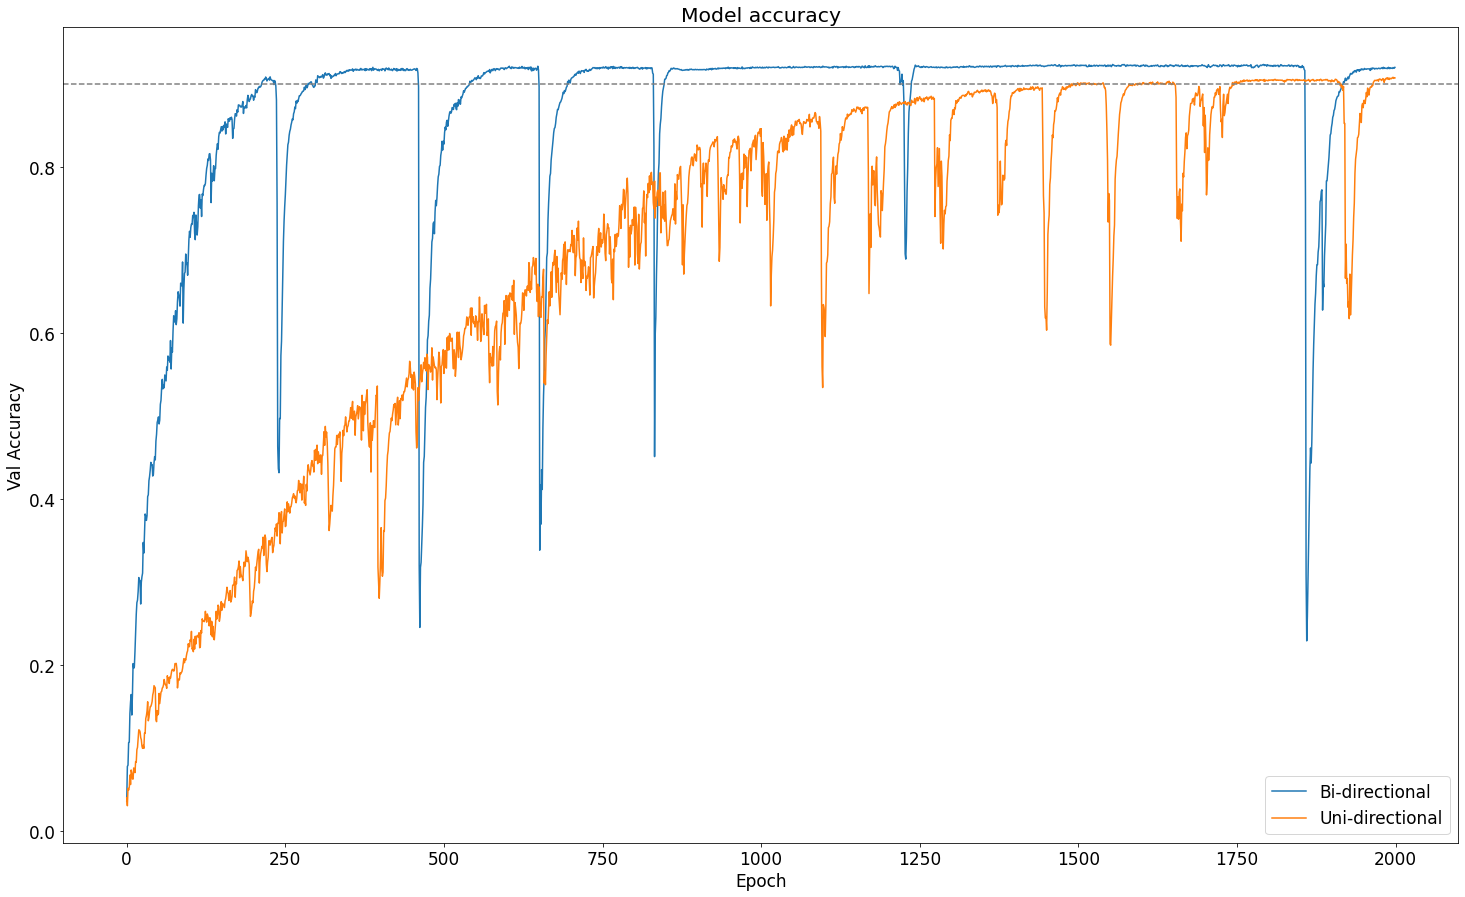

In [ ]:
#Plot training & validation accuracy values
plt.figure(figsize=(25, 15))
plt.plot(histB.history['val_acc'])
plt.plot(histU.history['val_acc'])
plt.axhline(0.9, color="grey", linestyle='--')
plt.title('Model accuracy')
plt.ylabel('Val Accuracy')
plt.xlabel('Epoch')
plt.legend(['Bi-directional', 'Uni-directional'], loc='lower right')
plt.show()

In [ ]:
os.chdir("/content")

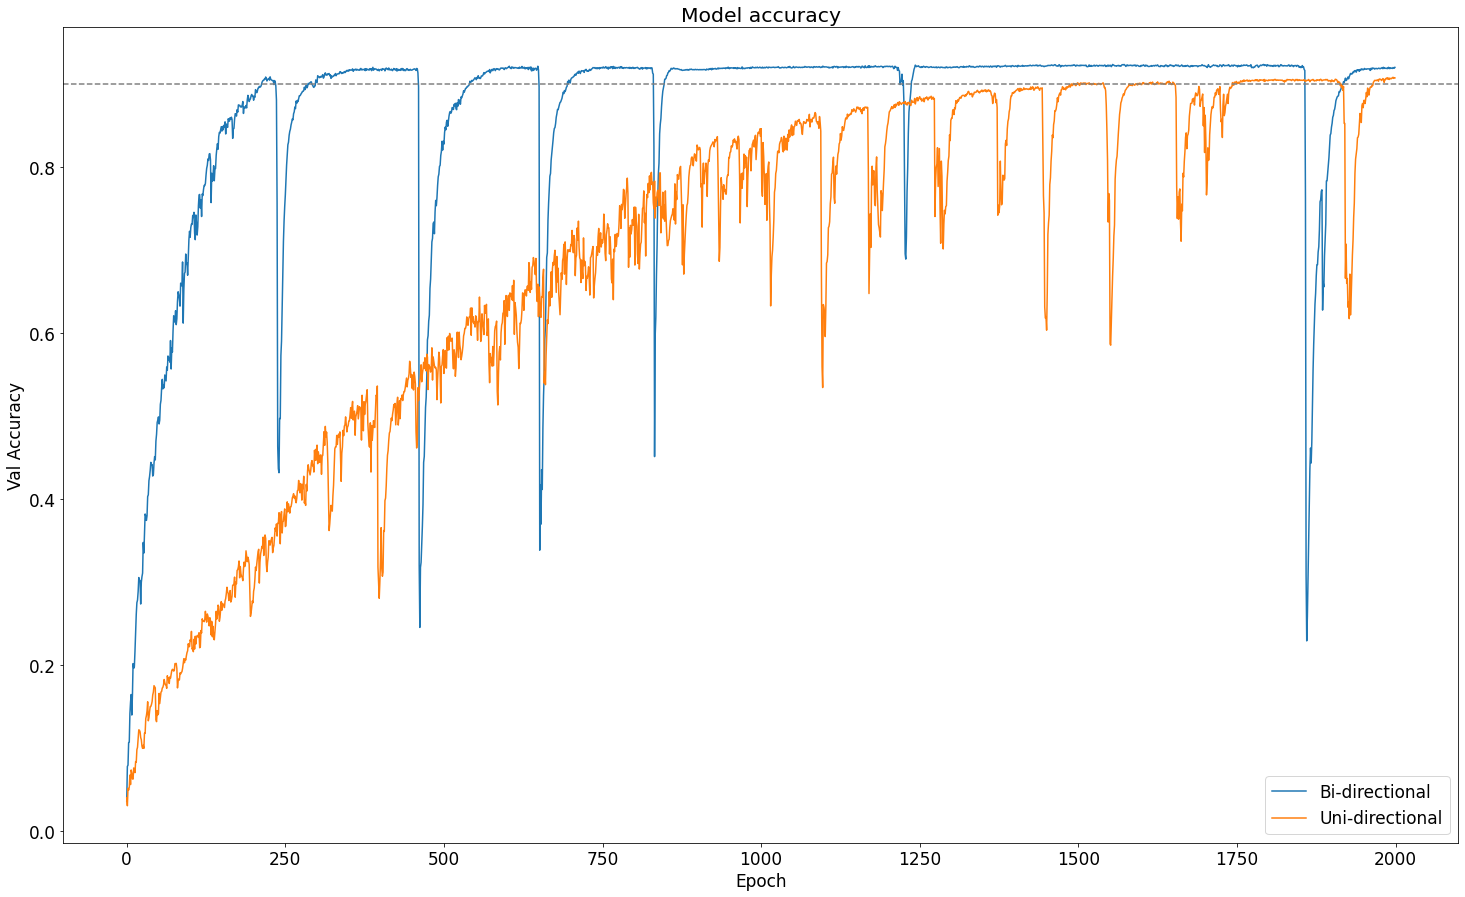

In [ ]:
#plt.rc('xtick', labelsize=23) 
font = {'size': 18}

plt.rc('font', **font)

#Plot training & validation accuracy values
fig = plt.figure(figsize=(25, 15))
plt.plot(histB.history['val_acc'])
plt.plot(histU.history['val_acc'])
plt.axhline(0.9, color="grey", linestyle='--')
#plt.title('Model accuracy')
plt.ylabel('Val Accuracy')
plt.xlabel('Epochs')
plt.legend(['Bi-directional', 'Uni-directional', '90% threshold'], loc='lower right')
plt.show()

fig.savefig("dir_confronto.pdf", bbox_inches='tight')